In [23]:
import numpy as np
import json
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os.path
import random
import PIL

In [24]:
import itertools
import sys
import cv2

In [25]:
meta_dir = r'C:\Users\Pundeer\Desktop\Data Science\Kaggle\amazon inventory reconciliation\amazon inventory\data\metadata'
img_dir = r'C:\Users\Pundeer\Desktop\Data Science\Kaggle\amazon inventory reconciliation\amazon inventory\data\bin-images'

In [33]:
N = range(10500)
num_samples = 4000
dataset_index = random.sample(N,num_samples)
#dataset_index

In [34]:
img_vec = []
meta_vec = []

for i in range(num_samples):
    fname_img = str(dataset_index[i]).zfill(5) + '.jpg'
    fname_meta = str(dataset_index[i]).zfill(5) + '.json'
    jpg_path = os.path.join(img_dir,fname_img)
    json_path = os.path.join(meta_dir,fname_meta)
    if os.path.isfile(jpg_path) & os.path.isfile(json_path):
        img_vec.append(fname_img)
        meta_vec.append(fname_meta)
        
print(np.shape(img_vec))
print(np.shape(meta_vec))

(3976,)
(3976,)


In [35]:
num_samples = len(img_vec)
#labels=np.zeros((num_samples,1))
labels = []
img_vec_less_5 = []
meta_vec_less_5 = []
for i in range(num_samples):
    fname_meta = meta_vec[i]
    fname_img = img_vec[i]
    json_path = os.path.join(meta_dir,fname_meta)
    f = open(json_path)
    dataset = json.load(f)
    expected_quantity = dataset['EXPECTED_QUANTITY']
    if expected_quantity <= 5:
        #print(fname)
        #print(expected_quantity)
        f.close()
        #labels[i,0]=expected_quantity
        labels.append(expected_quantity)
        img_vec_less_5.append(fname_img)
        meta_vec_less_5.append(fname_meta)
        
labels = np.array(labels, ndmin=2)
labels = labels.T
print(np.shape(labels))
print(np.shape(img_vec_less_5))
print(np.shape(meta_vec_less_5))

(2698, 1)
(2698,)
(2698,)


[1]


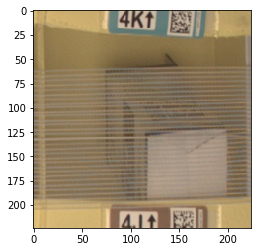

In [48]:
i = 555
fname = img_vec_less_5[i]
print(labels[i])
#fname = '00542.jpg'
jpg_path = os.path.join(img_dir,fname)
# Convert Image to array
img = PIL.Image.open(jpg_path)
resized_img = img.resize((224,224))
#plt.imshow(resized_img)
arr = np.array(resized_img)
plt.imshow(arr)
data_gray = color.rgb2gray(arr)
#plt.imshow(data_gray)
ppc = 16
fd, hog_image = hog(data_gray, orientations=8, pixels_per_cell=(ppc,ppc),
                    cells_per_block=(4, 4), block_norm = 'L2', visualize = True)

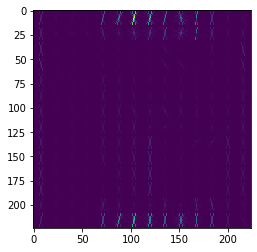

In [56]:
plt.imshow(hog_image)

In [50]:
laplacian = cv2.Laplacian(data_gray, cv2.CV_64F)
sobelx = cv2.Sobel(data_gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(data_gray, cv2.CV_64F, 0, 1, ksize=5)
np.shape(img)

(262, 384, 3)

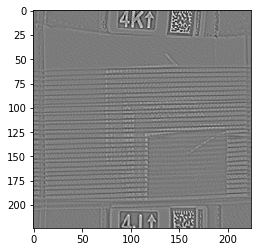

In [51]:
plt.imshow(laplacian,cmap = 'gray')

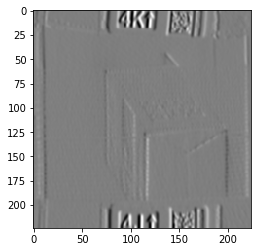

In [52]:
plt.imshow(sobelx,cmap = 'gray')

In [57]:
ppc = 16
hog_images = []
fd,hog_image = hog(laplacian, orientations=8, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(4, 4), block_norm = 'L2', visualize=True)

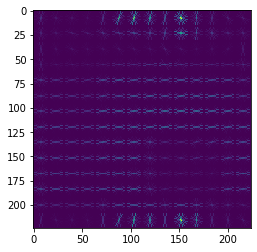

In [58]:
plt.imshow(hog_image)

In [59]:
hog_features_size = 15488
num_samples = len(meta_vec_less_5)
hog_features_matrix = np.zeros((num_samples, hog_features_size))

for i in range(num_samples):
    fname = img_vec_less_5[i]
    jpg_path = os.path.join(img_dir, fname)
    img = PIL.Image.open(jpg_path)
    resize_img = img.resize((224,224))
    arr = np.array(resize_img)
    data_grey = color.rgb2gray(arr)
    ppc = 16
    hog_images = []
    hog_features = []
    laplacian = cv2.Laplacian(data_grey, cv2.CV_64F)
    fd,hog_img = hog(laplacian, orientations = 8, pixels_per_cell = (ppc,ppc),
                    cells_per_block = (4,4), block_norm = 'L2', visualize = True)
    hog_images.append(hog_img)
    hog_features.append(fd)
    hog_features = np.array(hog_features)
    hog_features_matrix[i,:] = hog_features
np.shape(hog_features_matrix)

(2698, 15488)

In [60]:
df = np.hstack((hog_features_matrix, labels))
np.random.shuffle(df)
np.shape(df)

(2698, 15489)

In [61]:
partition = int(num_samples*0.9)

In [62]:
x_train, x_test = df[:partition,:-1], df[partition:,:-1]
y_train, y_test = df[:partition,-1].ravel() , df[partition:,-1].ravel()

In [23]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, folds):
    Cs = [0.1, 1, 10, 100]
    gammas = [0.1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=folds, verbose = 10, n_jobs = 2)
    grid_search.fit(X, y)
    grid_search.best_params_
    print('checkpoint')
    return grid_search.best_params_

In [24]:
nfolds = 3
best_params = svc_param_selection(x_train, y_train, nfolds)
best_params

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 33.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 33.5min finished


checkpoint


{'C': 0.01, 'gamma': 0.01}

In [25]:
C = best_params['C']
gamma = best_params['gamma']

In [68]:
clf = SVC(kernel = 'rbf', gamma = 0.1, C = 100)
clf.fit(x_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [69]:
y_pred = clf.predict(x_test)

In [70]:
clf.score(x_train, y_train)

1.0

In [71]:
clf.score(x_test,y_test)

0.25555555555555554

In [33]:
np.histogram(y_pred)

(array([  0,   0,   0,   0,   0, 339,   0,   0,   0,   0], dtype=int64),
 array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5]))

In [72]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.25555555555555554


              precision    recall  f1-score   support

         0.0       1.00      0.22      0.36         9
         1.0       0.50      0.08      0.13        26
         2.0       0.15      0.08      0.10        51
         3.0       0.28      0.72      0.41        80
         4.0       0.10      0.05      0.07        60
         5.0       0.00      0.00      0.00        44

    accuracy                           0.26       270
   macro avg       0.34      0.19      0.18       270
weighted avg       0.22      0.26      0.18       270



In [16]:
def confusion_plot(cm, classes, normalize = False):
    if normalize:
        cm = cm.astype(float)/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    print(cm)
    plt.imshow(cm, interpolation = 'nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()      

In [17]:
cnf_matrix = confusion_matrix(y_test, y_pred)

In [18]:
cnf_matrix

array([[ 1,  3,  1,  3,  0,  0],
       [ 0,  1, 15, 19,  1,  0],
       [ 0,  2, 14, 51,  6,  3],
       [ 0,  0,  6, 74, 12,  1],
       [ 0,  0,  9, 65,  4,  2],
       [ 0,  1,  6, 32,  5,  2]], dtype=int64)

In [19]:
class_names=[0,1,2,3,4,5]

Confusion matrix without normalization
[[ 1  3  1  3  0  0]
 [ 0  1 15 19  1  0]
 [ 0  2 14 51  6  3]
 [ 0  0  6 74 12  1]
 [ 0  0  9 65  4  2]
 [ 0  1  6 32  5  2]]


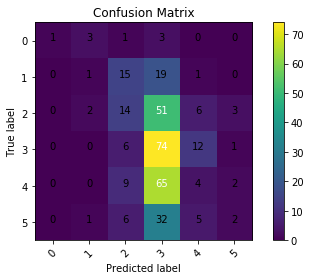

In [20]:
plt.figure()
confusion_plot(cnf_matrix, classes=class_names)

Normalized confusion matrix
[[0.125      0.375      0.125      0.375      0.         0.        ]
 [0.         0.02777778 0.41666667 0.52777778 0.02777778 0.        ]
 [0.         0.02631579 0.18421053 0.67105263 0.07894737 0.03947368]
 [0.         0.         0.06451613 0.79569892 0.12903226 0.01075269]
 [0.         0.         0.1125     0.8125     0.05       0.025     ]
 [0.         0.02173913 0.13043478 0.69565217 0.10869565 0.04347826]]


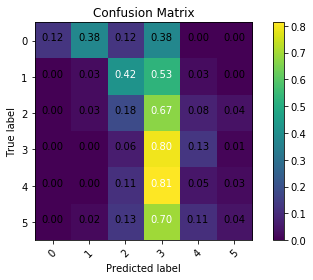

In [21]:
plt.figure()
confusion_plot(cnf_matrix, classes=class_names, normalize=True)